<a href="https://colab.research.google.com/github/marwahfaraj/Aircraft-Threat-Detection-Using-Computer-Vision/blob/main/notebooks/Aircraft_Threat_Detection_Team_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛫 Aircraft Threat Detection Using Computer Vision
### *Applied Computer Vision for AI (AAI-521-01) — University of San Diego, Fall 2025*

**Team Members:**  
- Andrew Blumhardt  
- Marwah Faraj  
- Patrick Woo-Sam  

---

### **Project Overview**

This project explores the use of **computer vision and deep learning** to identify and classify aircraft in static images and video feeds.  
Our objective is to detect aircraft, determine their type, and assess potential threat levels by distinguishing between **civilian and military models**.  

The team integrates modern techniques in **image preprocessing, feature extraction, transfer learning, and object detection** to develop a model capable of performing real-time aircraft recognition. This work demonstrates practical applications of visual AI in **aerospace monitoring, defense analysis, and early warning systems**, aligning with the principles of applied computer vision.

🧭 Team Setup Instructions

The datasets for this project are already prepared and stored in the shared Google Drive folder.
Team members only need to mount Drive to access them — no downloads or uploads are required.

Shared Drive Folder: AAI521_TeamProject

Steps to Prepare Your Environment

Open the link above and join the shared Drive folder as an Editor. https://drive.google.com/drive/folders/1psx8Iw6uC7uy6IKipU8PrK_1J4EOP7cC?usp=sharing

Verify you can see the following folders: AAI521_TeamProject/data/raw/

Mount Google Drive when prompted in Colab.

Run the setup cell below to verify your environment and folder structure.

In [1]:
# Author: Andrew Blumhardt
# Purpose: Import necessary libraries, set environment configurations, create directory structure.
# Notes: Include core Python, OpenCV, TensorFlow/Keras, Ultralytics (YOLO), and visualization libraries.
# Verify GPU availability and seed reproducibility.

!pip install ultralytics -q

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

print("\n📁 Google Drive mounted successfully.")

# ===============================================================
# Import Core Libraries
# ===============================================================
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from IPython.display import display
from ultralytics import YOLO

# ===============================================================
# Project Directory Verification (simple + clean)
# ===============================================================

primary_path = "/content/drive/MyDrive/AAI521_Project"
shared_path  = "/content/drive/Shared drives/AAI521_Project"

if os.path.exists(primary_path):
    project_dir = primary_path
    print(f"✅ Project directory found at: {project_dir}")
elif os.path.exists(shared_path):
    project_dir = shared_path
    print(f"✅ Project directory found at (Shared Drive): {project_dir}")
else:
    print("❌ Project directory not found.")
    print("➡️ Make sure the folder 'AAI521_Project' is added to your Google Drive.")
    raise SystemExit("Cannot continue without project folder access.")

# Raw data directory
raw_dir = os.path.join(project_dir, "data/raw")
print(f"📂 Raw data directory: {raw_dir}")

if not os.path.exists(raw_dir):
    print("❌ Raw directory missing. Verify folder structure.")
    raise SystemExit("Stopping until raw data is available.")
else:
    print("✔ Raw directory located.")

# ===============================================================
# Environment Configuration (Seeds + GPU)
# ===============================================================

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"\n🔢 Random seed set to {seed}")

gpu = tf.config.list_physical_devices("GPU")
if gpu:
    print(f"🚀 GPU available: {gpu[0].name}")
else:
    print("⚠️ No GPU detected. Enable GPU in Colab: Runtime → Change runtime type → GPU")

print("\n✨ Setup complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.8 MB/s eta 0:00:00
Mounted at /content/drive

📁 Google Drive mounted successfully.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Project directory found at: /content/drive/MyDrive/AAI521_Project
📂 Raw data directory: /content/drive/MyDrive/AAI521_Project/data/raw
✔ Raw directory located.

🔢 Random seed set to 42
🚀 GPU available: /physical_device:GPU:0

✨ Setup complete.


### 📝 Explanation
This setup block prepares the environment for the aircraft threat detection project by installing required libraries, mounting Google Drive, and establishing a consistent directory structure for all team members. Because the FGVC and Military Aircraft datasets are large and often cause timeouts when accessed through the Kaggle API, we manually downloaded, unzipped, and uploaded them into a shared Google Drive folder. The code checks for this shared project directory in either MyDrive or Shared drives to ensure everyone can access the same files. Once the raw data directory is confirmed, the block sets random seeds for reproducibility and checks for GPU availability to support faster training.

📂 FGVC (Commercial Aircraft) directory: /content/drive/MyDrive/AAI521_Project/data/raw/fgvc-aircraft-2013b-data
🔢 Commercial aircraft samples loaded: 10000
🛫 Unique commercial aircraft variants: 100


image_id                                         image_path    label  \
0  1025794  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   
1  1340192  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   
2  0056978  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   
3  0698580  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   
4  0450014  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   

     category  split  
0  Commercial  train  
1  Commercial  train  
2  Commercial  train  
3  Commercial  train  
4  Commercial  train


📸 Displaying 6 commercial aircraft images...


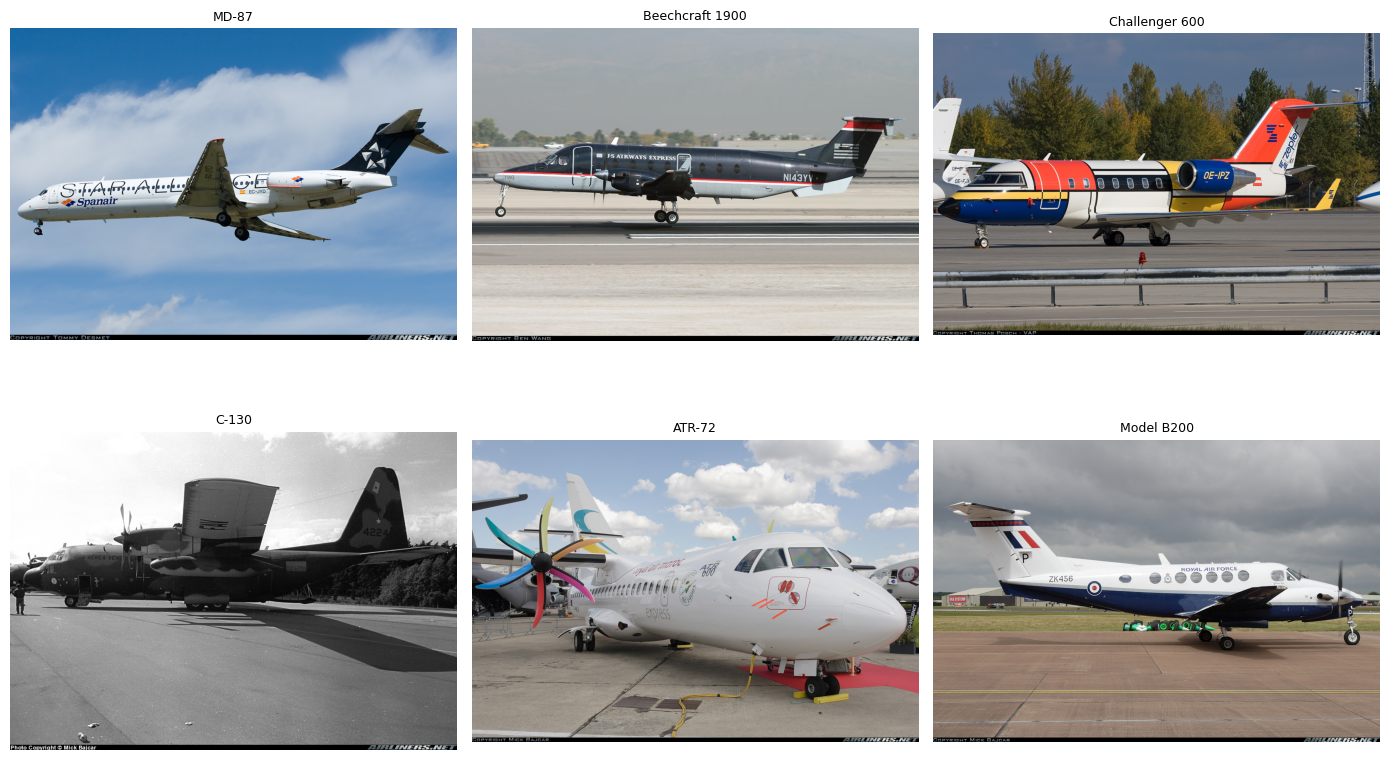

In [2]:
# Author: Andrew Blumhardt
# Purpose: Load the FGVC (Civilain) and Military Aircraft datasets, inspect metadata, and merge into a single structure.
# Notes: Display sample entries, record dataset size, and print available labels.

# --- FGVC (Commercial Aircraft) Paths ---
fgvc_dir = os.path.join(raw_dir, "fgvc-aircraft-2013b-data")
fgvc_data_dir = os.path.join(fgvc_dir, "data")
fgvc_img_dir = os.path.join(fgvc_data_dir, "images")

print("📂 FGVC (Commercial Aircraft) directory:", fgvc_dir)

# --- Annotation Files (variant-level labels) ---
variant_files = {
    "train": os.path.join(fgvc_data_dir, "images_variant_train.txt"),
    "val":   os.path.join(fgvc_data_dir, "images_variant_val.txt"),
    "test":  os.path.join(fgvc_data_dir, "images_variant_test.txt"),
}

# --- Load variant annotations ---
commercial_records = []

for split, filepath in variant_files.items():
    if not os.path.exists(filepath):
        print(f"⚠️ Missing annotation file: {filepath}")
        continue

    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) != 2:
                continue

            image_id, label = parts
            image_path = os.path.join(fgvc_img_dir, f"{image_id}.jpg")

            commercial_records.append({
                "image_id": image_id,
                "image_path": image_path,
                "label": label,
                "category": "Commercial",
                "split": split
            })

# --- Convert to DataFrame ---
commercial_df = pd.DataFrame(commercial_records)

print(f"🔢 Commercial aircraft samples loaded: {len(commercial_df)}")
print("🛫 Unique commercial aircraft variants:", commercial_df["label"].nunique())

display(commercial_df.head())

# ===============================================================
# 6-Image Grid Preview
# ===============================================================

print("\n📸 Displaying 6 commercial aircraft images...")

sample_rows = commercial_df.sample(6, random_state=42)

plt.figure(figsize=(14, 9))
for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img = plt.imread(row["image_path"])
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(row["label"], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



✈️ Loading Military Aircraft Dataset (CROP folders)...
📂 Military crop folder found: /content/drive/MyDrive/AAI521_Project/data/raw/crop

🔢 Military samples loaded (after filtering): 32599
🛩️ Unique detected military types: 96
📋 Classes: ['A10', 'A400M', 'AG600', 'AH64', 'AKINCI', 'AV8B', 'An124', 'An22', 'An225', 'An72', 'B1', 'B2', 'B21', 'B52', 'Be200', 'C1', 'C130', 'C17', 'C2', 'C390', 'C5', 'CH47', 'CH53', 'CL415', 'E2', 'E7', 'EF2000', 'EMB314', 'F117', 'F14', 'F15', 'F16', 'F18', 'F2', 'F22', 'F35', 'F4', 'FCK1', 'H6', 'Il76', 'J10', 'J20', 'J35', 'J36', 'J50', 'JAS39', 'JF17', 'JH7', 'KAAN', 'KC135', 'KF21', 'KJ600', 'Ka27', 'Ka52', 'MQ25', 'MQ9', 'Mi24', 'Mi26', 'Mi28', 'Mi8', 'Mig29', 'Mig31', 'Mirage2000', 'P3', 'RQ4', 'Rafale', 'SR71', 'Su24', 'Su25', 'Su34', 'Su47', 'Su57', 'TB001', 'TB2', 'Tejas', 'Tornado', 'Tu160', 'Tu22M', 'Tu95', 'U2', 'UH60', 'US2', 'V22', 'V280', 'Vulcan', 'WZ10', 'WZ7', 'WZ9', 'X29', 'X32', 'XB70', 'XQ58', 'Y20', 'YF23', 'Z10', 'Z19']


image_path label  category  height  \
0  /content/drive/MyDrive/AAI521_Project/data/raw...   A10  Military     706   
1  /content/drive/MyDrive/AAI521_Project/data/raw...   A10  Military     213   
2  /content/drive/MyDrive/AAI521_Project/data/raw...   A10  Military      97   
3  /content/drive/MyDrive/AAI521_Project/data/raw...   A10  Military     187   
4  /content/drive/MyDrive/AAI521_Project/data/raw...   A10  Military     291   

   width  
0   1768  
1    199  
2    268  
3    726  
4    207


📸 Displaying 6 military aircraft images...


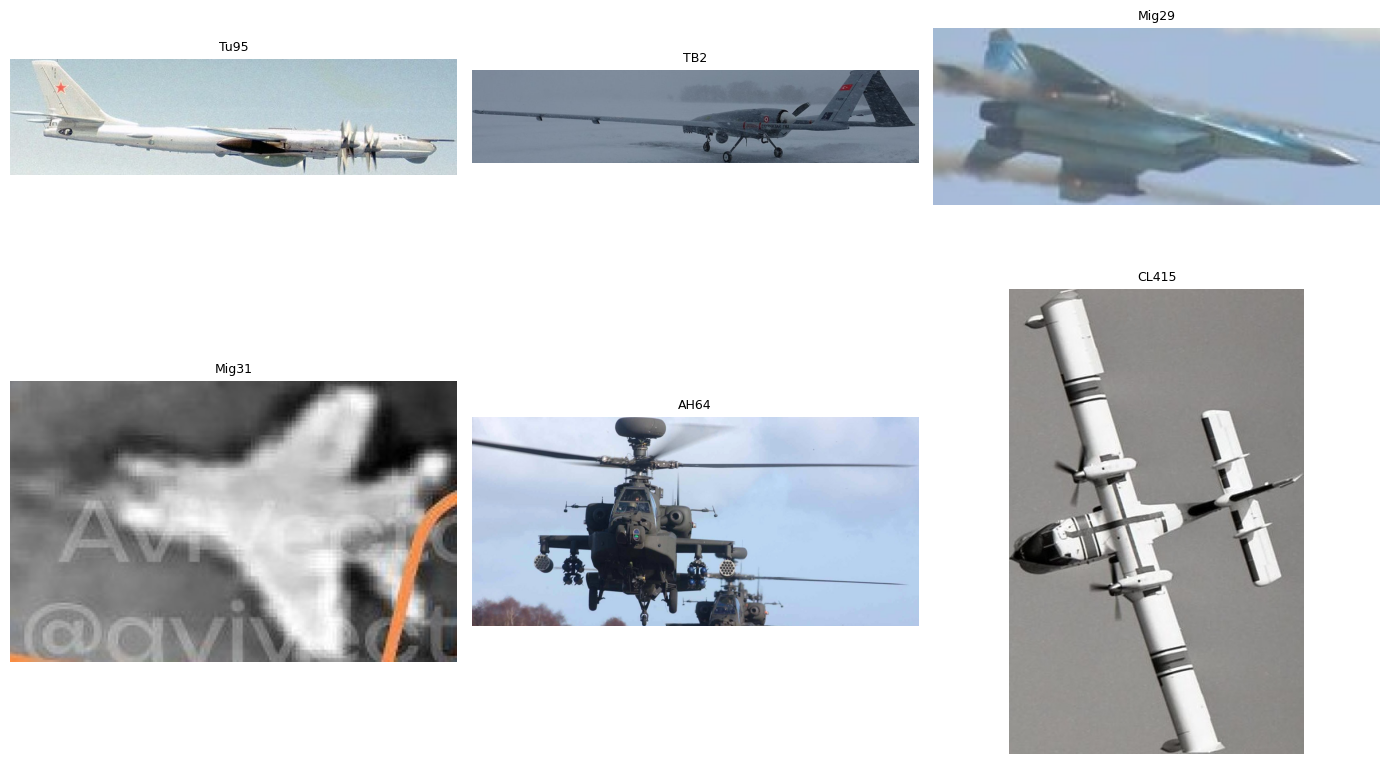

In [3]:
# Purpose: Load the Military Aircraft dataset
# This can take 10 min on CPU due to lable processing

print("\n✈️ Loading Military Aircraft Dataset (CROP folders)...")

military_crop_dir = os.path.join(raw_dir, "crop")

# Check existence
if not os.path.exists(military_crop_dir):
    print(f"❌ 'crop' folder not found at: {military_crop_dir}")
    raise SystemExit("Stopping until crop folder is available.")
else:
    print(f"📂 Military crop folder found: {military_crop_dir}")

# --- Minimum acceptable image size ---
min_size = 64   # filter out micro-crops smaller than 64x64 pixels

mil_records = []

for root, _, files in os.walk(military_crop_dir):
    label = os.path.basename(root)  # folder name = aircraft type

    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(root, f)

            # Load image to check resolution
            try:
                img = cv2.imread(image_path)
                if img is None:
                    continue
                h, w = img.shape[:2]
            except:
                continue

            # Skip tiny crops
            if h < min_size or w < min_size:
                continue

            # Save record
            mil_records.append({
                "image_path": image_path,
                "label": label,
                "category": "Military",
                "height": h,
                "width": w
            })

military_df = pd.DataFrame(mil_records)

print(f"\n🔢 Military samples loaded (after filtering): {len(military_df)}")
print("🛩️ Unique detected military types:", military_df["label"].nunique())
print("📋 Classes:", sorted(military_df["label"].unique()))

display(military_df.head())

# ===============================================================
# 6-image grid preview
# ===============================================================

print("\n📸 Displaying 6 military aircraft images...")

sample_rows = military_df.sample(6, random_state=42)

plt.figure(figsize=(14, 9))
for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img = plt.imread(row["image_path"])
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(row["label"], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


🔗 Merging Commercial and Military datasets...
📦 Total combined samples: 42599
🛫 Commercial samples: 10000
✈️ Military samples: 32599

🟦 Unique Commercial aircraft classes: 100
🟥 Unique Military aircraft classes: 96
🟨 Combined unique aircraft types: 195


image_id                                         image_path    label  \
0  1025794  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   
1  1340192  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   
2  0056978  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   
3  0698580  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   
4  0450014  /content/drive/MyDrive/AAI521_Project/data/raw...  707-320   

     category  split  height  width  
0  Commercial  train     NaN    NaN  
1  Commercial  train     NaN    NaN  
2  Commercial  train     NaN    NaN  
3  Commercial  train     NaN    NaN  
4  Commercial  train     NaN    NaN

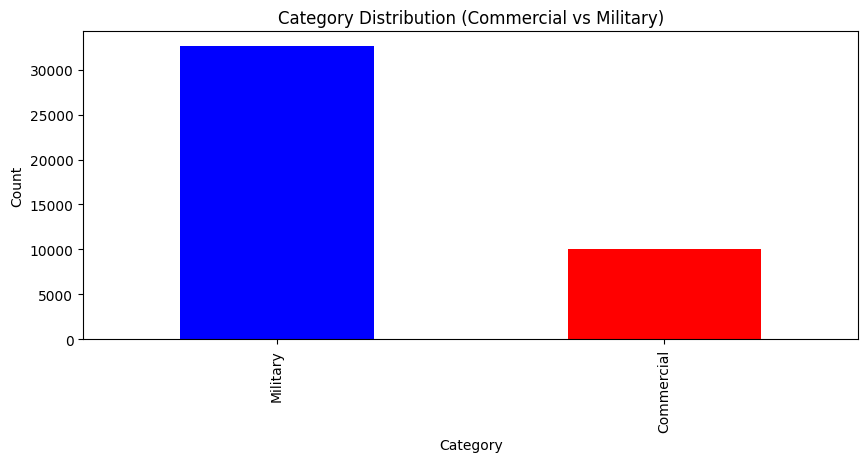


🖼️ Displaying 12 random thumbnails from combined dataset...


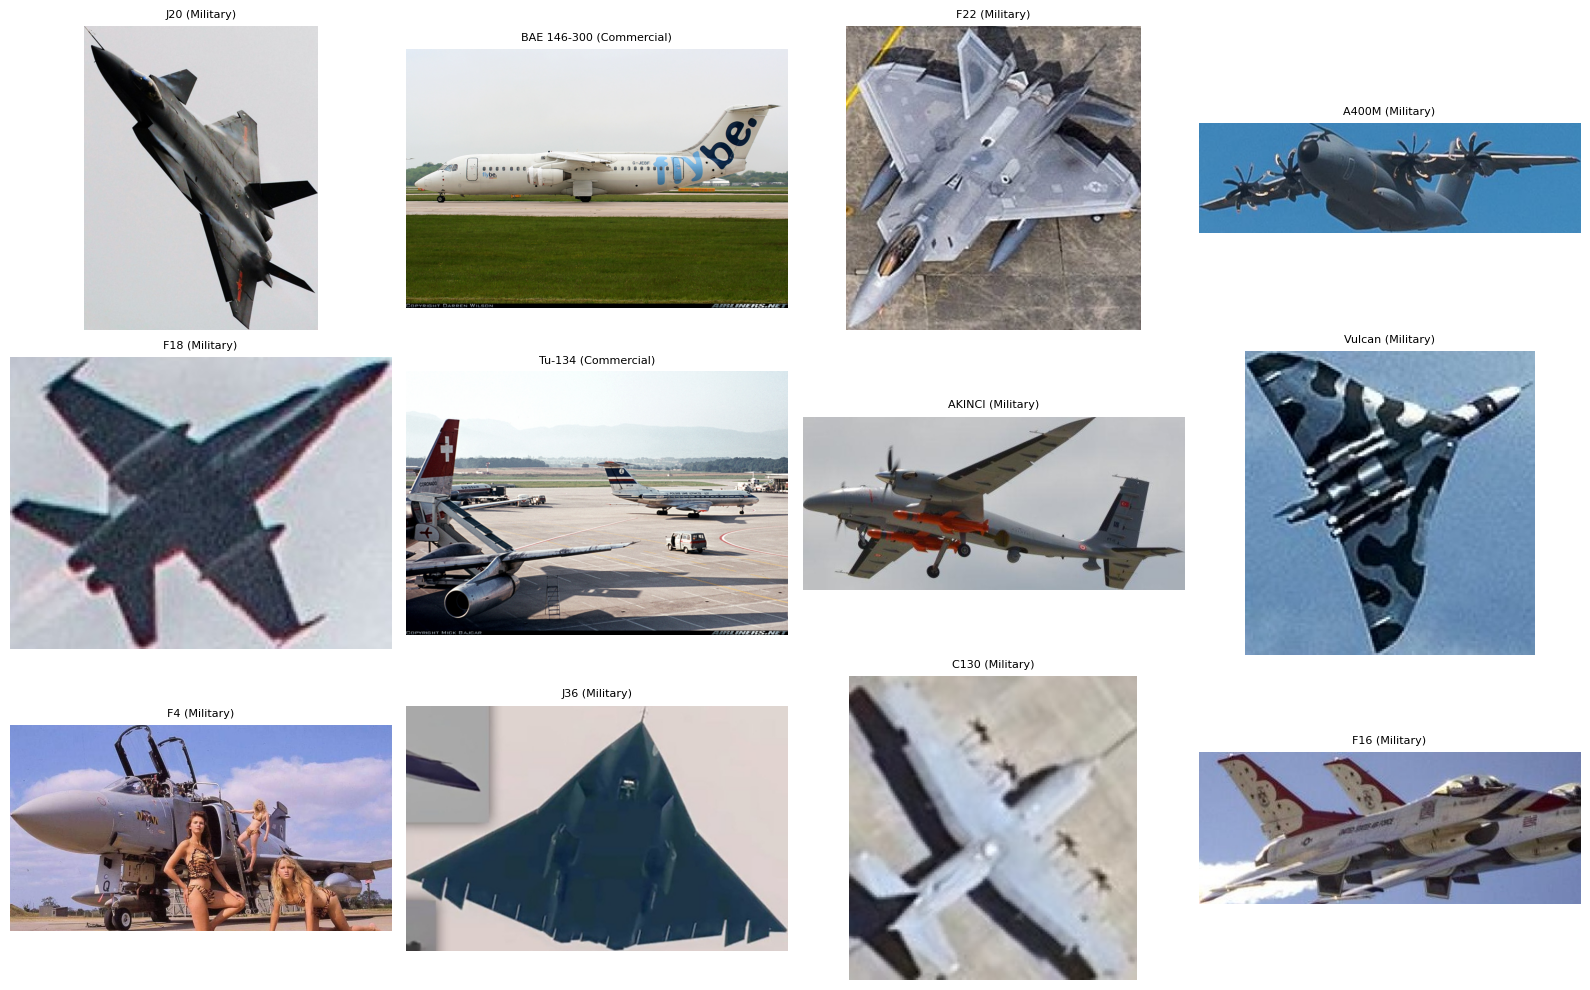

In [ ]:
# Purpose: Combine Commercial (FGVC) and Military datasets
# into a unified labeled structure for classification.

print("\n🔗 Merging Commercial and Military datasets...")

# Ensure the expected DataFrames exist
required_cols = {"image_path", "label", "category"}

if not required_cols.issubset(commercial_df.columns):
    raise ValueError("commercial_df missing required columns.")

if not required_cols.issubset(military_df.columns):
    raise ValueError("military_df missing required columns.")

# --- Combine into unified dataset ---
combined_df = pd.concat([commercial_df, military_df], ignore_index=True)

print(f"📦 Total combined samples: {len(combined_df)}")
print("🛫 Commercial samples:", (combined_df["category"] == "Commercial").sum())
print("✈️ Military samples:", (combined_df["category"] == "Military").sum())

# --- Display summary ---
print("\n🟦 Unique Commercial aircraft classes:", commercial_df["label"].nunique())
print("🟥 Unique Military aircraft classes:", military_df["label"].nunique())
print("🟨 Combined unique aircraft types:", combined_df["label"].nunique())

display(combined_df.head())

# ===============================================================
# Check class balance (for reporting)
# ===============================================================

plt.figure(figsize=(10, 4))
combined_df["category"].value_counts().plot(kind="bar", color=["blue", "red"])
plt.title("Category Distribution (Commercial vs Military)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# ===============================================================
# Print samples
# ===============================================================

print("\n🖼️ Displaying 12 random thumbnails from combined dataset...")

sample_rows = combined_df.sample(12, random_state=42)

plt.figure(figsize=(16, 10))

for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img = plt.imread(row["image_path"])
    plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.title(f"{row['label']} ({row['category']})", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

### 📝 Explanation
This project uses three structured dataset components that support progressively more advanced modeling. The first component, the FGVC Aircraft dataset, provides over ten thousand commercial aircraft images labeled at the variant level, offering clean, high-resolution examples of civilian aircraft. The second component is the Military Aircraft dataset, sourced from Kaggle, which organizes aircraft types into subfolders and provides cropped images of tactical aircraft. These images vary in size and quality, so smaller, unusable samples are filtered out to maintain consistency. After loading and validating each dataset independently, the two sources are merged into a single unified structure that includes the image path, aircraft label, and a category field distinguishing Commercial from Military. This combined dataset forms the foundation for a classifier capable of identifying aircraft type while also determining whether a given image represents a potential military threat, directly supporting the goals of the Aircraft Threat Detection project.

In [ ]:
# Author: [Name of Contributor]
# Purpose: Clean and standardize images for model input.
# Notes: Resize, normalize, handle corrupt or missing images, and standardize label encoding.
#        Consider creating functions to automate image preprocessing.

# (Write your preprocessing code here)

### 📝 Explanation
Discuss how preprocessing improved data consistency, what transformations were applied, and why certain image dimensions or normalization ranges were chosen.

In [ ]:
# Author: [Name of Contributor]
# Purpose: Explore class distribution, visualize samples, identify imbalance or biases.
# Notes: Include plots (class counts, image samples, heatmaps of bounding boxes if applicable).

# (Write your EDA code here)

### 📝 Explanation
Interpret your findings from EDA. Note any class imbalances, visual insights, or anomalies that may affect modeling.

In [ ]:
# Author: [Name of Contributor]
# Purpose: Build and evaluate a simple baseline classifier using pretrained CNN (e.g., ResNet50 or MobileNet).
# Notes: Freeze base layers, train only top layers. Establish initial accuracy and confusion matrix.

# (Write your baseline model code here)

### 📝 Explanation
Explain how the baseline model performed and what insights it gave you about model complexity and data quality.

In [ ]:
# Author: [Name of Contributor]
# Purpose: Implement an advanced model (YOLOv8, EfficientNet, or similar).
# Notes: Configure hyperparameters, training parameters, and augmentations.
#        Save best weights and evaluate using validation data.

# (Write your model training code here)

### 📝 Explanation
Summarize the model architecture, training observations (loss/accuracy trends), and compare to the baseline.

In [ ]:
# Author: [Name of Contributor]
# Purpose: Evaluate model performance using precision, recall, F1-score, confusion matrix, and mAP if applicable.
# Notes: Visualize metrics and sample predictions.

# (Write your evaluation code here)

### 📝 Explanation
Interpret performance results. Highlight key success areas, misclassifications, and potential causes for errors.

In [ ]:
# Author: [Name of Contributor]
# Purpose: Create a logic or model extension to classify threat level (civilian vs. military vs. unknown).
# Notes: Combine detection output with label-based classification rules or an additional model.

# (Write your threat classification code here)

### 📝 Explanation
Describe how the threat classification decision process works and evaluate its accuracy or limitations.

In [ ]:
# Author: [Name of Contributor]
# Purpose: Demonstrate inference on video or webcam feed using trained model.
# Notes: Process video frame-by-frame and visualize bounding boxes with predictions.

# (Write your real-time detection code here)

### 📝 Explanation
Discuss the real-time demo results and practical considerations like frame rate, detection latency, and visualization clarity.

In [ ]:
# Author: [Name of Contributor]
# Purpose: Aggregate model metrics, visualize comparisons, and summarize findings.
# Notes: Present charts comparing baseline vs. final model and provide insights for improvement.

# (Write your results summary code here)

### 📝 Explanation
Reflect on overall results, lessons learned, and areas for future enhancement (data augmentation, larger datasets, etc.).

In [ ]:
# Author: [All Team Members]
# Purpose: Document roles, GitHub branch contributions, and collaboration notes.
# Notes: Include references to pull requests, code merges, and review comments.

# (Add documentation of team workflow here)

### 📝 Explanation
Briefly describe how responsibilities were divided and managed throughout the project lifecycle.

In [ ]:
# Author: [Name of Contributor]
# Purpose: Cite datasets, libraries, and academic sources (APA 7 format).
# Notes: Include links to FGVC Aircraft and Military Aircraft datasets.

# (Add citations and any supporting materials here)

### 📝 Explanation
Provide a short overview of reference use and any additional materials included in the appendix (graphs, logs, or tables).